Epoch 1/100
18/18 [==============================] - 1s 4ms/step - loss: 3.4559
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 2.6609
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 2.4162
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 2.2622
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 2.1250
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 2.0322
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 1.9499
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 1.8697
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7934
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7404
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 1.7721
Epoch 12/100
18/18 [==============================] - 0s 4ms/step - loss: 1.9793
Epoch 13/100
18/18 [=================

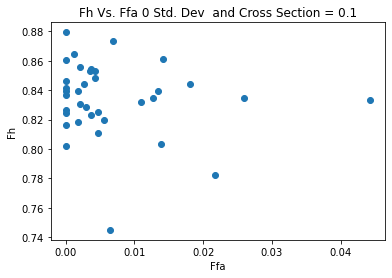

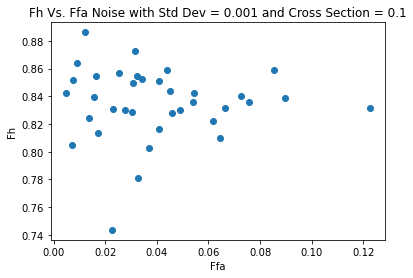

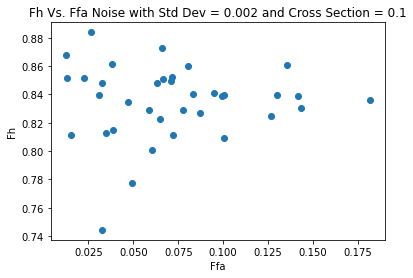

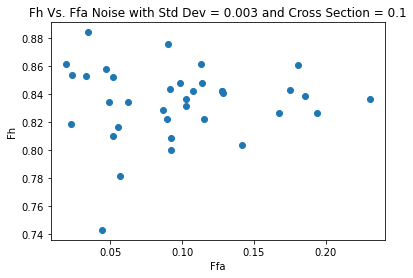

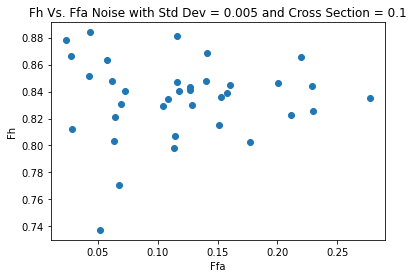

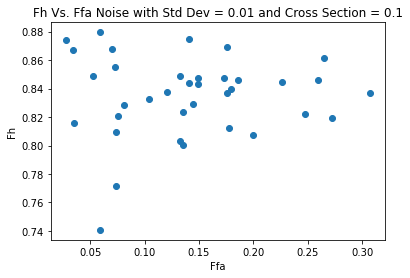

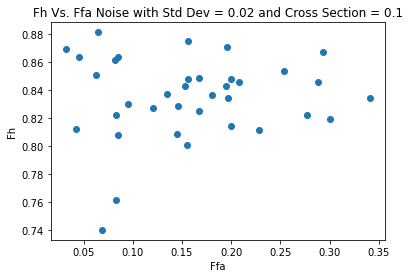

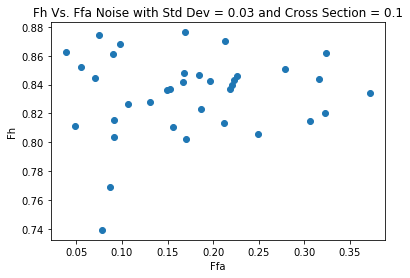

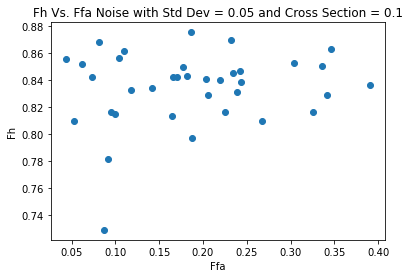

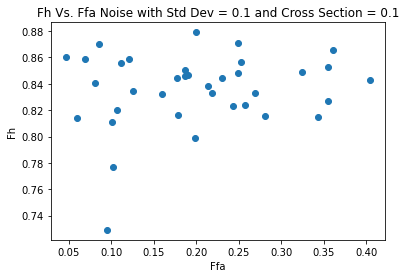

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.82     0.01        0.8          0.01        0.84         0           0.84         0           0.83         0.04      

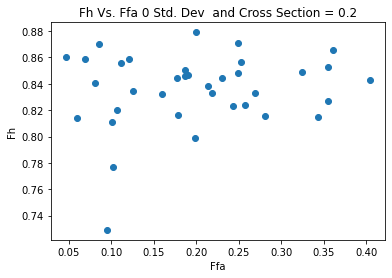

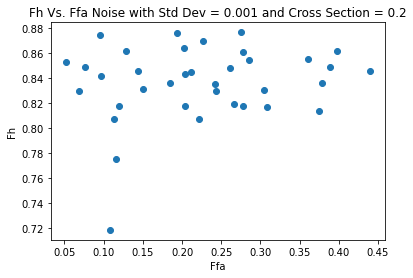

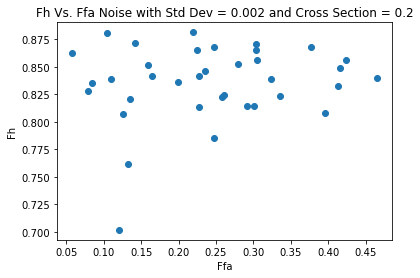

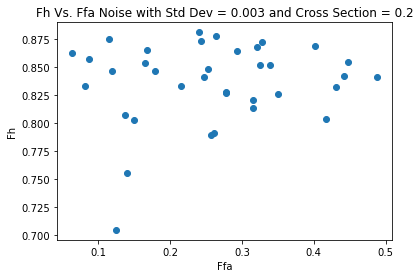

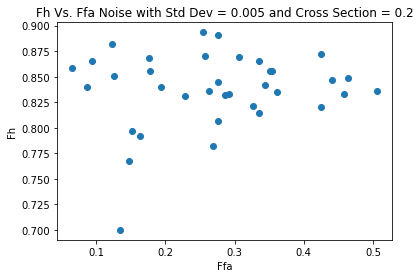

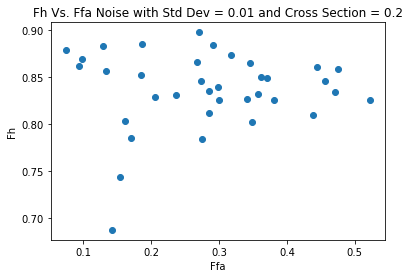

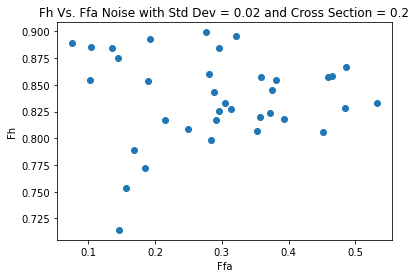

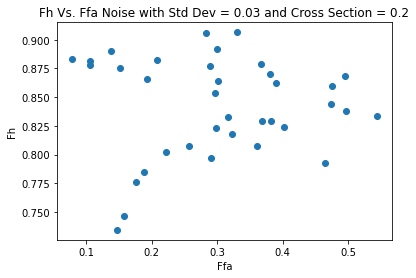

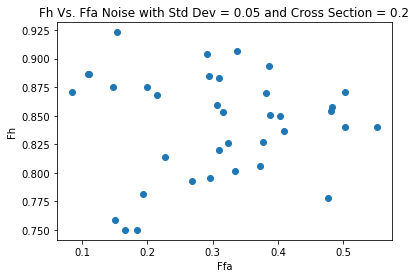

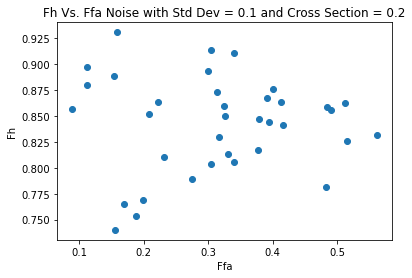

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.81     0.34        0.82         0.18        0.85         0.32        0.83         0.22        0.82         0.26      

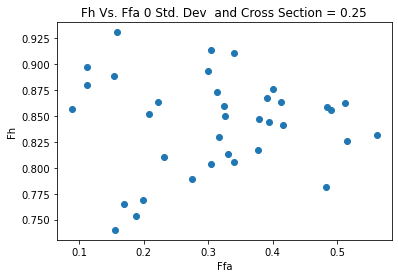

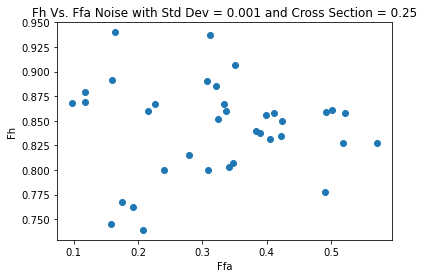

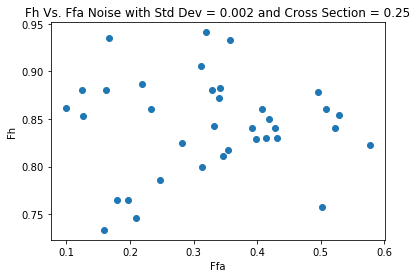

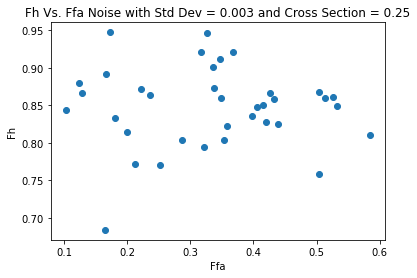

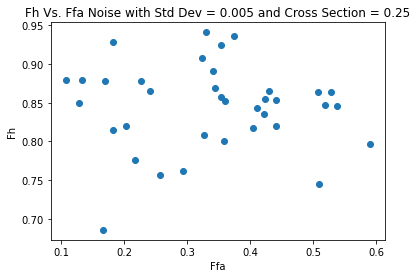

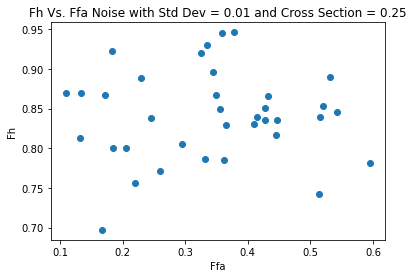

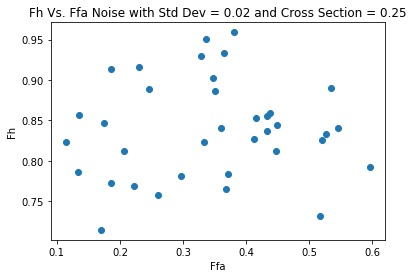

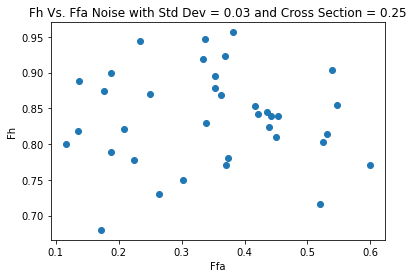

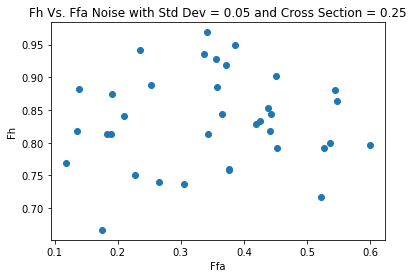

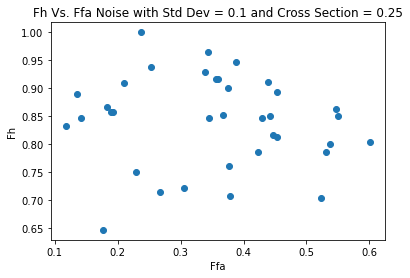

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.78     0.48        0.8          0.3         0.86         0.48        0.81         0.33        0.82         0.38      

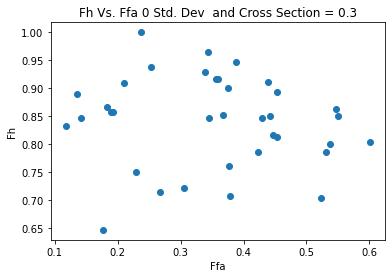

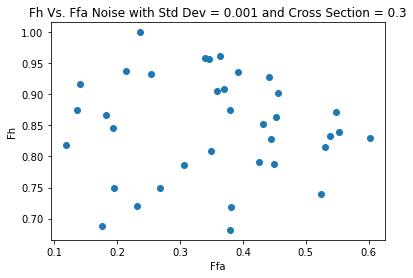

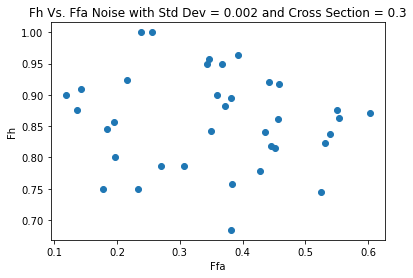

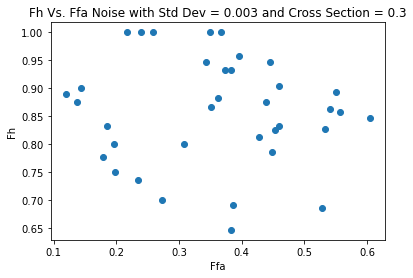

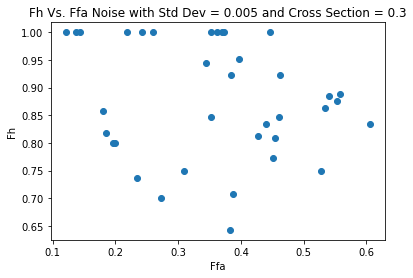

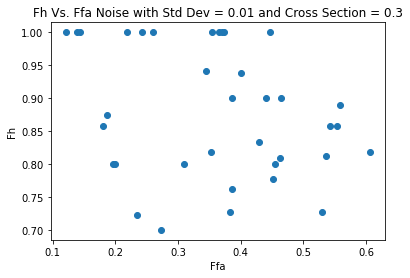

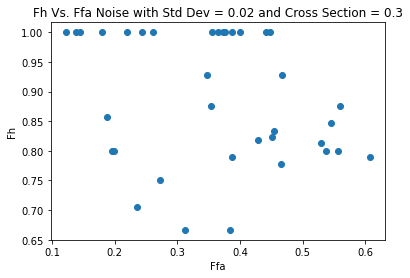

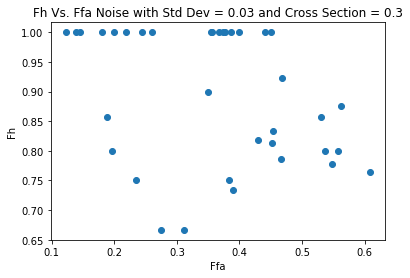

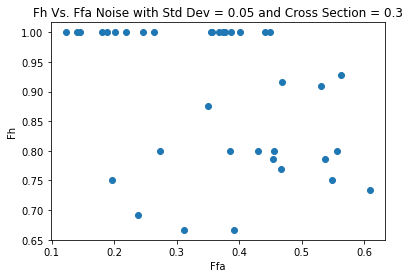

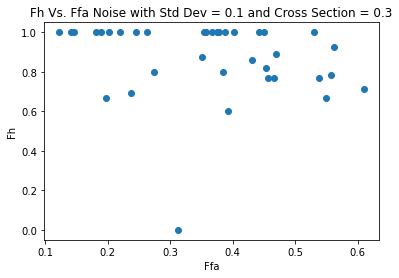

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.7      0.52        0.85         0.35        0.79         0.53        0.76         0.38        0.79         0.42      

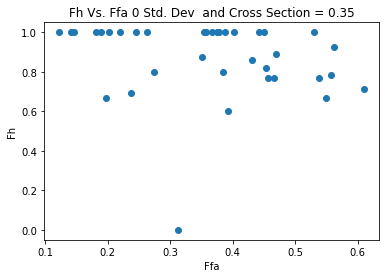

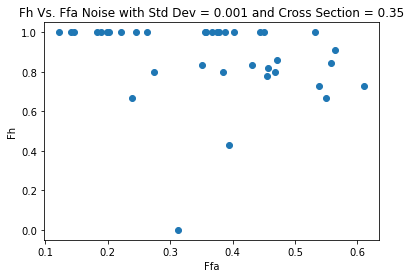

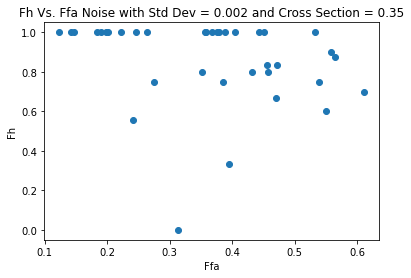

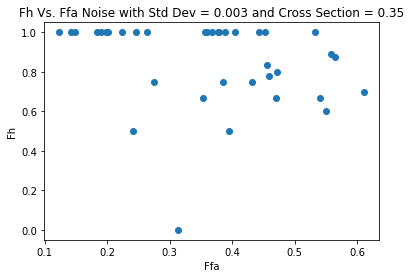

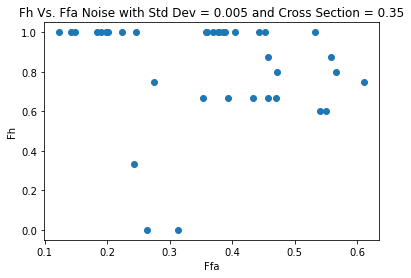

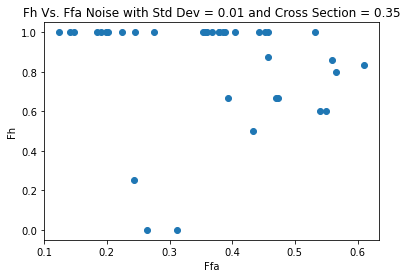

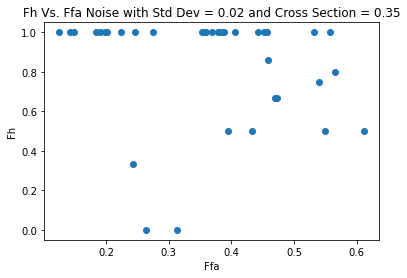

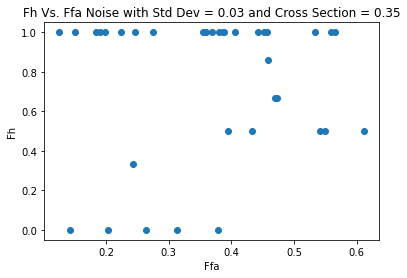

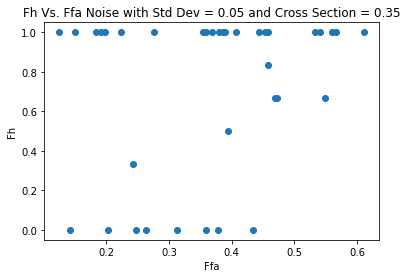

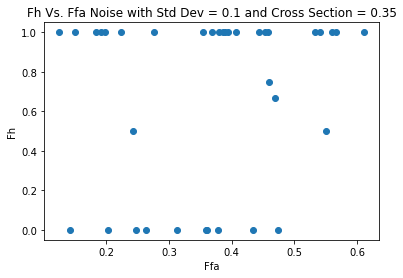

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0       1     0.53           1         0.35        0.77         0.54        0.6          0.39        0.86         0.43      

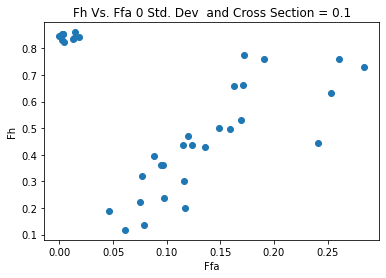

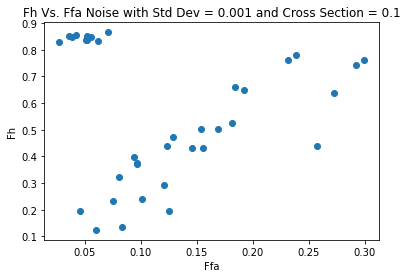

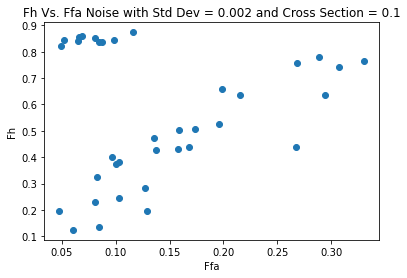

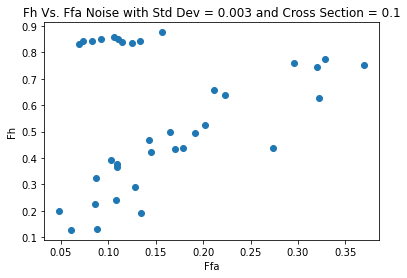

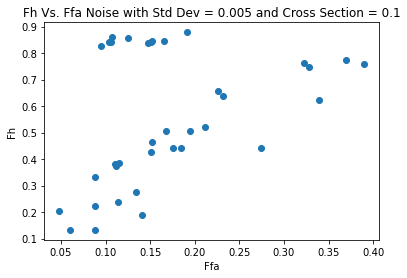

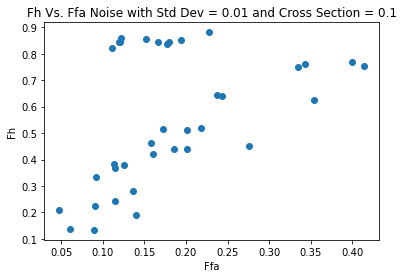

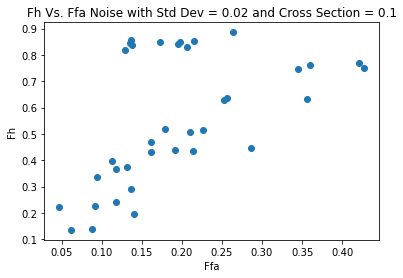

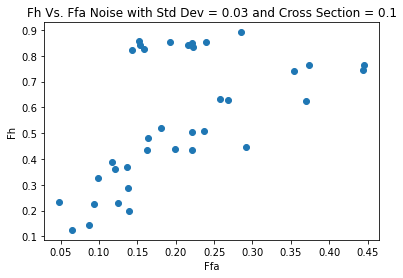

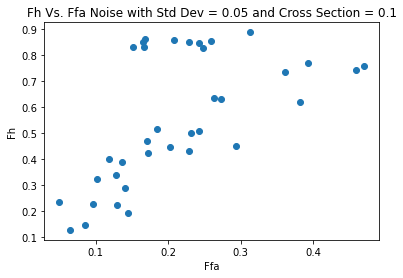

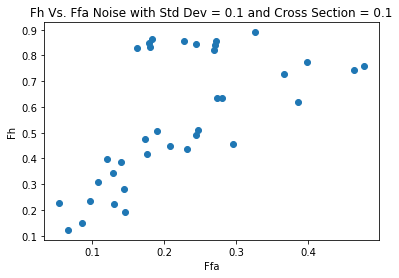

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.63     0.25        0.5          0.16        0.2          0.12        0.44         0.12        0.45         0.24      

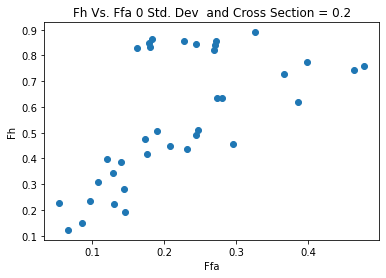

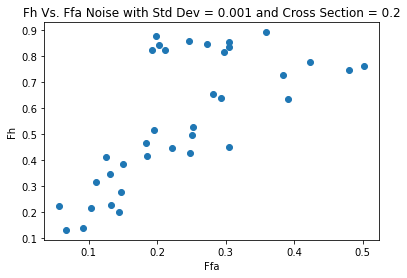

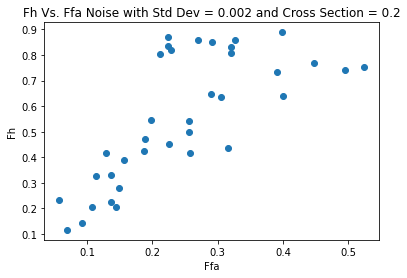

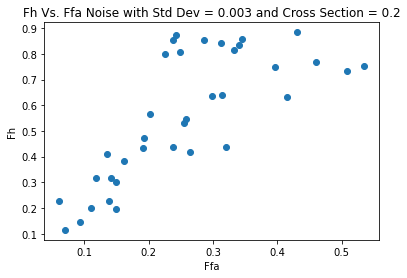

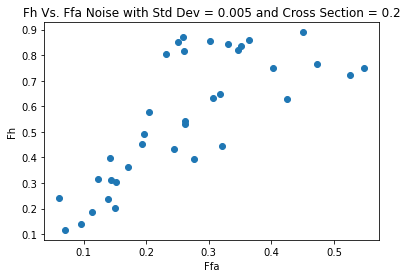

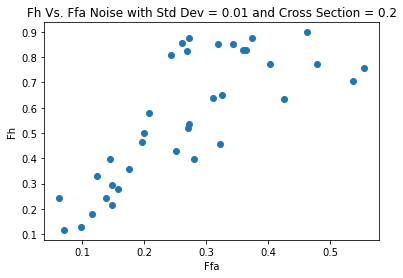

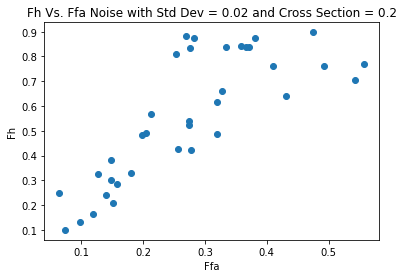

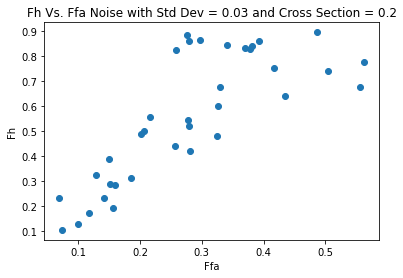

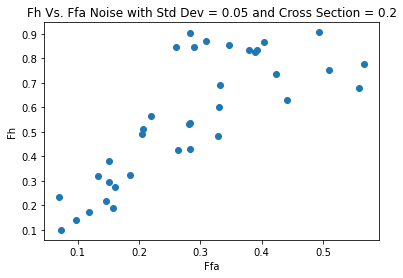

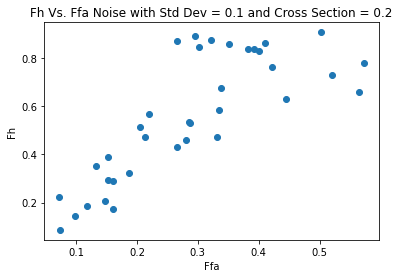

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.62     0.39        0.49         0.24        0.19         0.15        0.45         0.21        0.45         0.3       

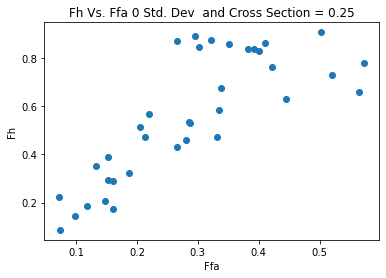

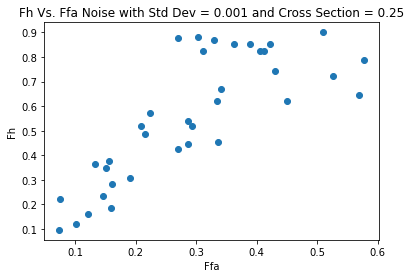

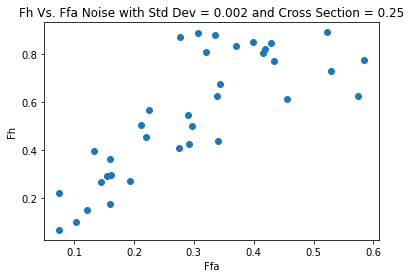

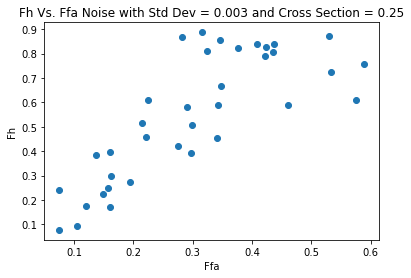

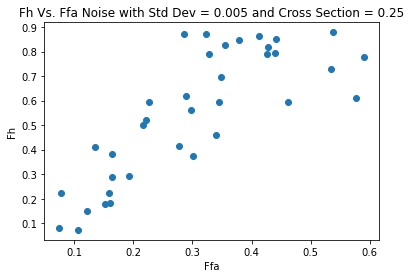

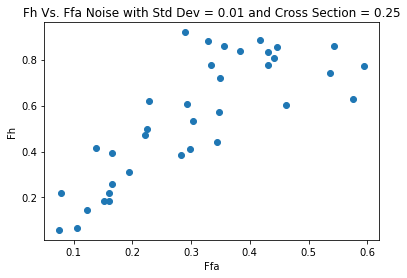

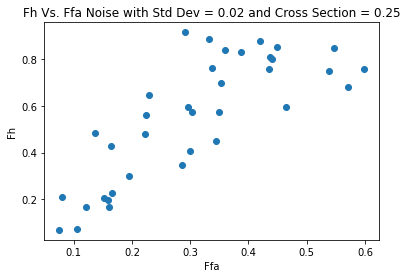

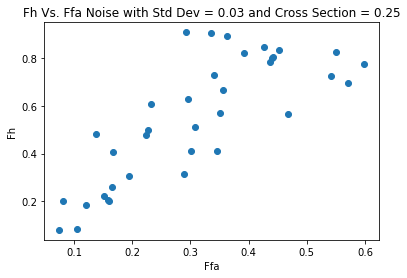

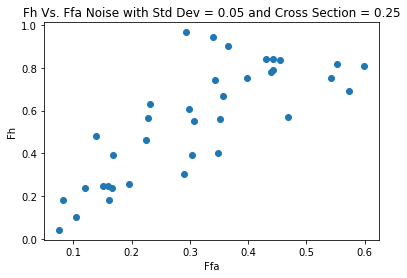

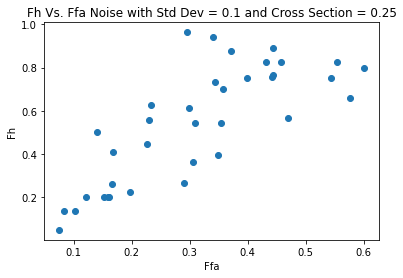

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.63     0.44        0.53         0.29        0.17         0.16        0.43         0.27        0.47         0.33      

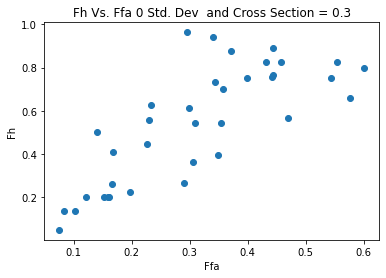

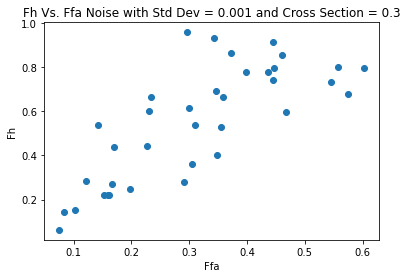

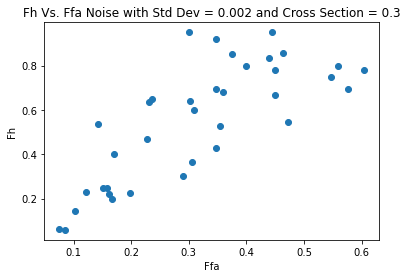

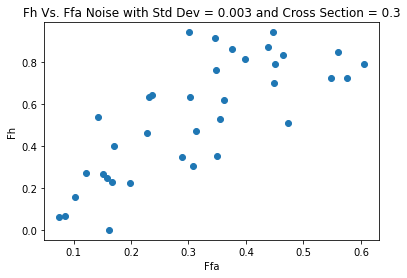

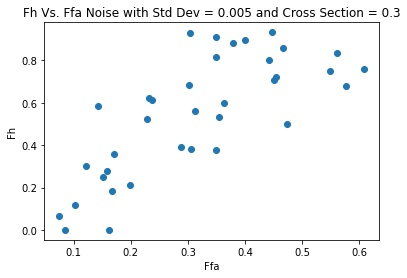

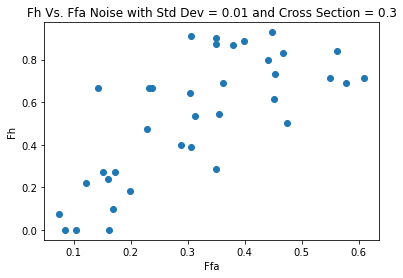

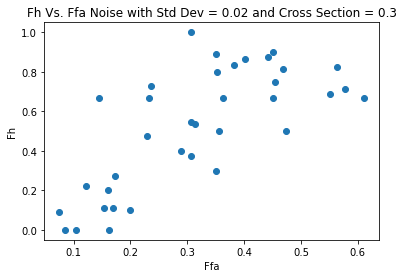

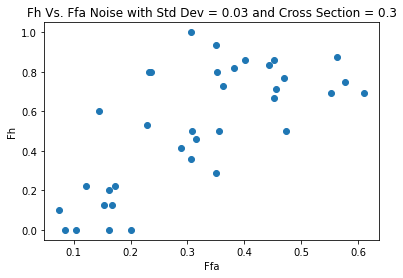

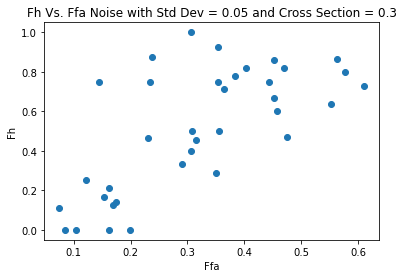

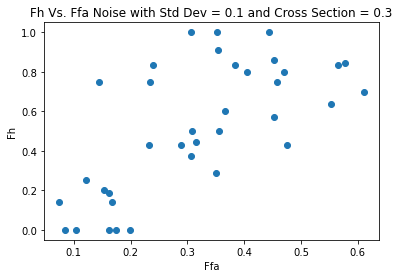

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.57     0.47        0.54         0.31        0.2          0.16        0.27         0.29        0.39         0.35      

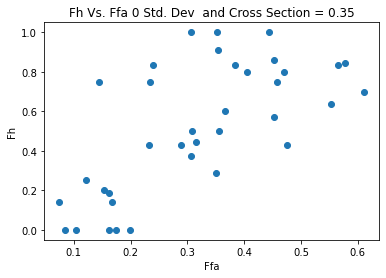

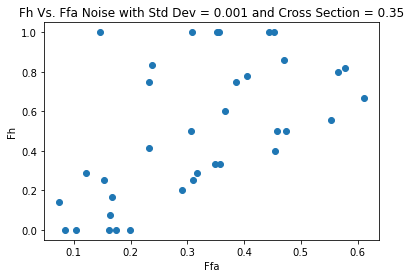

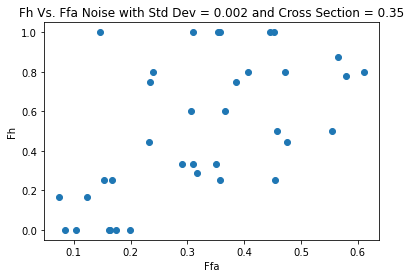

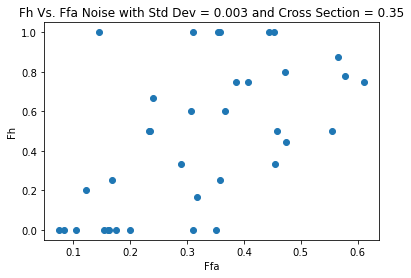

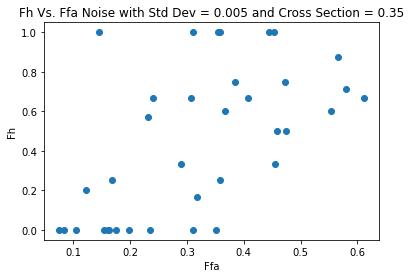

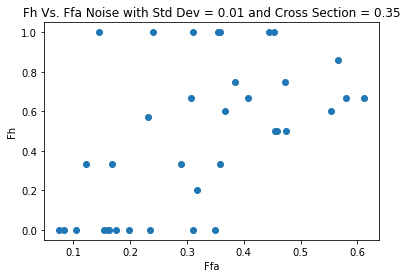

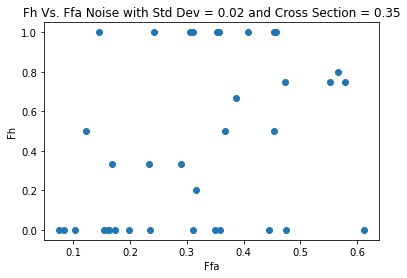

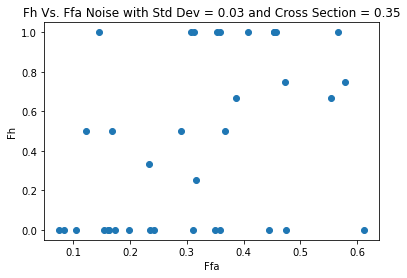

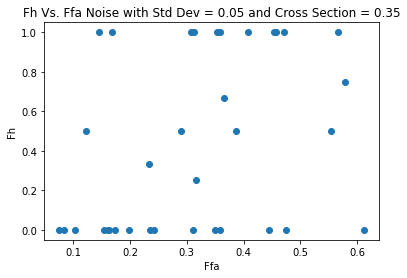

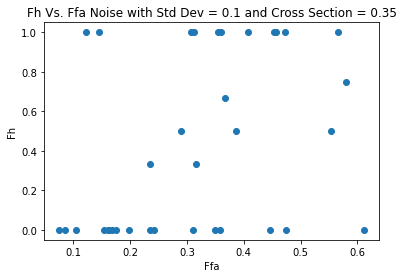

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 32.0x32.0 = 1024.0
Number of Weights in an Equivalent Single-Layer Perceptron = 32.0x32.0 = 1024.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 32768
Number of Weights in Hidden Layer 2 = 32768
Number of Weights in Hidden Layer 3 = 147456
Number of Outputs = 32x32 = 1024
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.43     0.48        0.44         0.32        0.19         0.16        0.43         0.29        0.29         0.35      

In [35]:
import cv2 
from math import *
import math
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv
import numpy
import random
from tabulate import tabulate

alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
            'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 
            'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
            'y', 'z', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9']

def toBlackWhiteBinary(img):
    
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] < 128:
                img[i][j] = 0
                
            else:
                img[i][j] = 255
            
    
    return img

def makeBinaryImages():                
    for i in alphabet:
        path = list("./CharDataset1/x.jpg")
        path[len(path) - 5] = str(i)
        path = "".join(path)
        print(path, "\n")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        print(type(img))
        img = toBlackWhiteBinary(img)
        cv2.imwrite(path, img)
        
def ImageToArray(img):
    final = []
    for i in range(len(img)):
        for j in range(len(img[1])):
            final.append(img[i][j])
            
    for i in range(len(final)):
        if final[i] == 255:
            final[i] = 1
        else:
            final[i] = 0
    return final

def compareImage(Original, Output):
    mismatch = 0
    for i in range(len(Original)):
        if Output[i] != Original[i]:
            mismatch += 1
    return mismatch / len(Original)

#gets all dataset 1 images
def DataSetOfAllImages(num, size):
    dataset = []
    size = int(size / 16)
    for i in alphabet:
        path = list("./CharDatasetx/y.jpg")
        path[len(path) - 5] = str(i)*size
        path[13] = str(num)
        path = "".join(path)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img.setflags(write = 1)
       
        dataset.append(ImageToArray(img))
    return dataset

def Threshold(Arr):
    newArr = []
    for i in Arr:
        if i > 0.5:
            newArr.append(1)
        else:
            newArr.append(0)
    return newArr

def ThresholdResultArrays(arrs):
    newArr = []
    for i in arrs:
        newArr.append(Threshold(i))
    return newArr

def CountWhitePixels(img):
    count = 0
    for i in img:
        if i == 0:
            count += 1
    return count

def ComputeFh(correctImage, Output):
    TotalBlackPixels = 0
    TotalCorrectPixels = 0
    
    for i in range(len(correctImage)):
        if correctImage[i] == 1:
            TotalBlackPixels += 1
            if(Output[i] == 1):
                TotalCorrectPixels += 1
    
    if TotalBlackPixels == 0:
        TotalBlackPixels += 1
        
    return TotalCorrectPixels / TotalBlackPixels

def ComputeFhArray(correctImages, OutputImages):
    fhArr = []
    for i in range(len(correctImages)):
        fhArr.append(ComputeFh(correctImages[i], OutputImages[i]))
    return fhArr

def ComputeFfa(correctImage, Output):
    TotalWrongPixels = 0
    
    for i in range(len(correctImage)):
        if (Output[i] == 1) and (correctImage[i] != 1):
            TotalWrongPixels += 1
    
    if CountWhitePixels(correctImage) == 0:
        return TotalWrongPixels
    
    return TotalWrongPixels / CountWhitePixels(correctImage)

def ComputeFfaArray(correctImages, OutputImages):
    ffaArr = []
    for i in range(len(correctImages)):
        ffaArr.append(ComputeFfa(correctImages[i], OutputImages[i]))
    return ffaArr

#Images would be X
def Perturb(images, mean, std_dev, cs):
    
    NoiseCorruptedImages = []
    
    for i in images:
        currentImage = i
        
        mean, std_dev = mean, std_dev
        
        num = round(cs * len(i))

        sample = numpy.random.normal(mean, std_dev, num)

        RandomImageIndexes = random.sample(range(0, len(i)), num)
        
        sampleIndex = 0
        
        for j in RandomImageIndexes:
            currentImage[j] += sample[sampleIndex]
            sampleIndex += 1
        NoiseCorruptedImages.append(currentImage)
        
    return ThresholdResultArrays(NoiseCorruptedImages)
            
    
    
def Model(X, y):
    
    model = Sequential()
    model.add(Dense(256, input_dim = 256, activation='relu'))
    #model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=10, batch_size=2, verbose = True)
    return model

def MultiLayerModel(X, y):
    
    model = Sequential()
    model.add(Dense(128, input_dim = 256, activation='relu'))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=20, batch_size=2, verbose = True)
    return model

def SixteenAutoAssociativeDeepModel(X, y, _epochs, _batch_size, V = False):
    
    model = Sequential()
    
    model.add(Dense(128, input_dim = 256, activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=_epochs, batch_size=_batch_size, verbose = V)
    return model

def ThirtyTwoAutoAssociativeDeepModel(X, y, _epochs, _batch_size, V = False):
    
    model = Sequential()
    
    model.add(Dense(128, input_dim = 1024, activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=_epochs, batch_size=_batch_size, verbose = V)
    return model

def RunAnalysis(X, Y, model, plotTitle=None):
    
    FhArray = ComputeFhArray(X, Y)
    FfaArray = ComputeFfaArray(X, Y)
    
    
    #print(FhArray)
    #print(FfaArray)
    
    plt.scatter(FfaArray, FhArray)
    plt.title(plotTitle)
    plt.xlabel("Ffa")
    plt.ylabel("Fh")
    plt.show()
    
    return [FhArray, FfaArray]

def Tabulate(FhArrays, FfaArrays, M, dim, num = 3):
    #(["Image 0",FhStdDev0, FfaStdDev0, ..., FhStdDev0.1, FfaStdDev0.1])
    table = []
    for i in range(10):
        newEntry = []
        newEntry.append(str(i))
        for j in range(len(FhArrays)):
            newEntry.append(str(round(FhArrays[i][j], 2)))
            newEntry.append(str(round(FfaArrays[i][j], 2)))
        table.append(newEntry)
        
    print("Table of Autoassociative Deep Neural Network Response to Noisy Input")
    print("Number of Inputs = " + str(dim) + "x" + str(dim) + " = " + str(dim * dim))
    print("Number of Weights in an Equivalent Single-Layer Perceptron = " + str(dim) + "x" + str(dim) + " = " + str(dim * dim) + "K")
    print("Number of Hidden Layers in This DNN = " + str(num))
    #print(M.layers[num - 1].output.shape[1])
    
    for i in range(num):
        print("Number of Weights in Hidden Layer " + str(i + 1) + " = " + str(M.layers[i].output.shape[1] * M.layers[i + 1].output.shape[1] + M.layers[i + 1].output.shape[1] * M.layers[i + 2].output.shape[1]))
        
    
    print("Number of Outputs = " + str(int(math.sqrt(M.layers[num + 1].output.shape[1]))) + "x" + str(int(math.sqrt(M.layers[num + 1].output.shape[1]))) + " = " + str(int(M.layers[num + 1].output.shape[1])))
    
    
    
    print(tabulate(table, headers = ["Image", "Fh 0", "Ffa 0", "Fh 0.001", "Ffa 0.001",
                                     "Fh 0.002", "Ffa 0.002", "Fh 0.003", "Ffa 0.003", 
                                     "Fh 0.005", "Ffa 0.005", "Fh 0.01", "Ffa 0.01", 
                                    "Fh 0.02", "Ffa 0.02", "Fh 0.03", "Ffa 0.03", 
                                     "Fh 0.05", "Ffa 0.05", "Fh 0.1", "Ffa 0.1"]))
    
def FinalPlot(FhArrays, FfaArrays, Std_Devs):
    
    for i in range(len(FhArrays)):
        for j in range(len(FhArrays[i])):
            for k in Std_Devs:
                plt.scatter(k, FhArrays[i][j], color='blue')
                plt.scatter(k, FfaArrays[i][j], color = 'red')
    plt.title("Graph of Fh and Ffa vs. Noise Standard Deviation for noise-corrupted Alphanumeric Imagery (16x16 pixels) for Autoassociative Single-Layer Perceptron")
    
    plt.xscale('log')
    plt.xlabel("Gaussian Noise Level (stdev, at 10 pct xsecn)")
    plt.xlim([0, 0.1])
    #plt.xticks(numpy.arange(0, 0.1, 0.001))
    
    plt.ylim([0, 1])
    plt.ylabel("Fh and Ffa")
    
    plt.legend(["Blue = Fh", "Red = Ffa"])
    
    plt.show()
        
def RunExperiment(X, M):
    #print(X[1])
    print("Predicting Dataset")
    Y = ThresholdResultArrays(M.predict(X))
    print("Running Analysis")
    
    
    
    stdDevs = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
    cs = [0.1, 0.2, 0.25, 0.3, 0.35]
    
    
    print("Testing with Noise")
    
    
    for j in cs:
        a = RunAnalysis(X, Y, M, "Fh Vs. Ffa 0 Std. Dev " + " and Cross Section = " + str(j))
        FhArrays = []
        FfaArrays = []
        FhArrays.append(a[0])
        FfaArrays.append(a[1])
        for i in stdDevs:
            NoisyImages = Perturb(X, 0, i, j)
            a = RunAnalysis(NoisyImages, Y, M, "Fh Vs. Ffa Noise with Std Dev = " + str(i) + " and Cross Section = " + str(j))
            FhArrays.append(a[0])
            FfaArrays.append(a[1])
            
        Tabulate(FhArrays, FfaArrays, M, math.sqrt(len(X[0])))
    
   
        
    
    stdDevs = [0] + stdDevs
    #FinalPlot(FhArrays, FfaArrays, stdDevs)


    
def main():
            
    X = numpy.array(DataSetOfAllImages(1, 32))
    X2 = numpy.array(DataSetOfAllImages(2, 32))
    y = X
    
    M = ThirtyTwoAutoAssociativeDeepModel(X, y, 100, 2, True)
    print("Running Experiment with Original Dataset")
    RunExperiment(X, M)
    print("Running Experiment with Dataset #2")
    RunExperiment(X2, M)
    
    
        
main()

        
        



